In [73]:
import numpy as np
import matplotlib.pyplot as plt

In [74]:
def theta(y, V_c, t_f, t):
    return y/(V_c*(t_f - t))

def dx_hat_prop(F, x_hat, K, z, V_c, t_f, t):
    # print(K@(z-(x_hat[0]/(V_c*(t_f-t)))))
    dx = F@x_hat + K*(z-(x_hat[0]/(V_c*(t_f-t))))
    return dx

In [ ]:
def run_sim():
    # Constants
    V_c = 300 # ft/s
    R_1 = 15*10e-6 # rad^2/s
    R_2 = 1.67*10e-3 # rad^2/s^3
    t_f = 10 # s
    tau = 2.0 # s

    E_a_T_2 = 100**2 # (ft/sec^2)^2
    E_a_T = 0
    E_y_t0 = 0
    E_y_t0_2 = 0

    E_v_t0 = 0
    E_v_t0_2 = 200**2 # (ft/sec)^2

    W = np.array([[0, 0, 0],
                [0, 0, 0],
                [0, 0, E_a_T_2]])

    a_p = 0

    F = np.array([[0, 1, 0],
                [0, 0, -1],
                [0, 0, -1/tau]])

    B = np.array([[0, 1, 0]]).T

    G = np.array([[0, 0, 1]]).T

    # Sim startup
    dt = 0.01 # s
    time = np.arange(0, t_f, dt)

    H = np.array([[1/(V_c*t_f), 0, 0]])
    V = R_1 + R_2/(t_f**2)

    P = np.array([[0, 0, 0],
                [0, E_v_t0_2, 0],
                [0, 0, E_a_T_2]])
    K = P@H.T/V

    n = np.random.normal(0, np.sqrt(V/dt))
    w_a_T = np.random.normal(E_a_T, np.sqrt(E_a_T_2/dt))


    x = np.array([[0.0],
                [np.random.normal(E_v_t0, np.sqrt(E_v_t0_2))], 
                [np.random.normal(E_a_T, np.sqrt(E_a_T_2))]])
    dx = np.zeros((3, 1))
    z = H@x + n
    x_hat = np.zeros((3, 1))
    dx_hat = dx_hat_prop(F, x_hat, K, z, V_c, t_f, 0)

    P_hist = np.zeros((len(time), 3, 3))
    K_hist = np.zeros((len(time), 3, 1))
    x_hist = np.zeros((len(time), 3, 1))
    dx_hist = np.zeros((len(time), 3, 1))
    z_hist = np.zeros(len(time))
    residual = np.zeros(len(time))
    x_hat_hist = np.zeros((len(time), 3, 1))
    dx_hat_hist = np.zeros((len(time), 3, 1))

    P_hist[0] = P
    K_hist[0] = K
    x_hist[0] = x
    dx_hist[0] = dx
    z_hist[0] = np.squeeze(z)
    x_hat_hist[0] = x_hat
    dx_hat_hist[0] = dx_hat

    for i in range(1, len(time)):
        V = R_1 + R_2/((t_f - time[i])**2)
        H = np.array([[1/(V_c*(t_f - time[i])), 0, 0]])

        # Variance update
        dP = F@P + P@F.T - P@H.T*(1/V)*H@P+W
        P = P + dP*dt
        P_hist[i, :, :] = P

        # Kalman Gain
        K = P@H.T/V
        K_hist[i, :, :] = K

        dx_hat = F@x_hat + K@(z - (H@x_hat))
        dx_hat_hist[i] = dx_hat

        x_hat = x_hat + dx_hat*dt
        x_hat_hist[i] = x_hat


        n = np.random.normal(0, np.sqrt(V/dt))
        w_a_T = np.random.normal(E_a_T, np.sqrt(E_a_T_2/dt))
        
        dx = F@x + G*w_a_T
        dx_hist[i] = dx

        x = x + dx*dt
        x_hist[i] = x
        
        z = H@x + n
        z_hist[i] = np.squeeze(z)
        residual[i] = np.squeeze(z - H@x_hat)

    return time, P_hist, K_hist, x_hist, dx_hist, z_hist, x_hat_hist, dx_hat_hist, residual


    

In [76]:
time, P_hist, K_hist, x_hist, dx_hist, z_hist, x_hat_hist, dx_hat_hist, residual = run_sim()

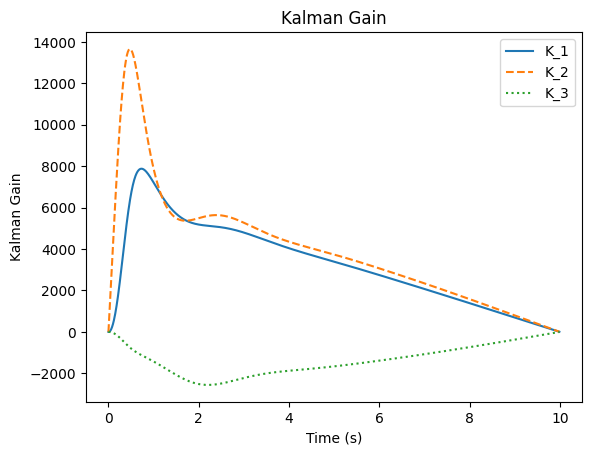

In [77]:
plt.plot(time, K_hist[:, 0, 0], label='K_1')
plt.plot(time, K_hist[:, 1, 0], label='K_2', linestyle='--')
plt.plot(time, K_hist[:, 2, 0], label='K_3', linestyle=':')
plt.title('Kalman Gain')
plt.xlabel('Time (s)')
plt.ylabel('Kalman Gain')
plt.legend()

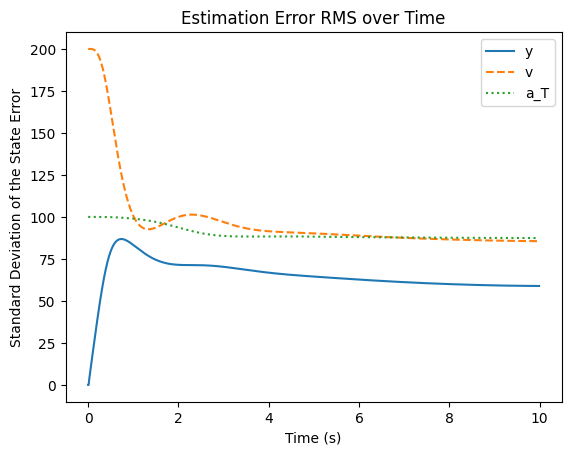

In [78]:
plt.plot(time, np.sqrt(P_hist[:, 0, 0]), label='y')
plt.plot(time, np.sqrt(P_hist[:, 1, 1]), label='v', linestyle='--')
plt.plot(time, np.sqrt(P_hist[:, 2, 2]), label='a_T', linestyle=':')
plt.title('Estimation Error RMS over Time')
plt.xlabel('Time (s)')
plt.ylabel('Standard Deviation of the State Error')
plt.legend()

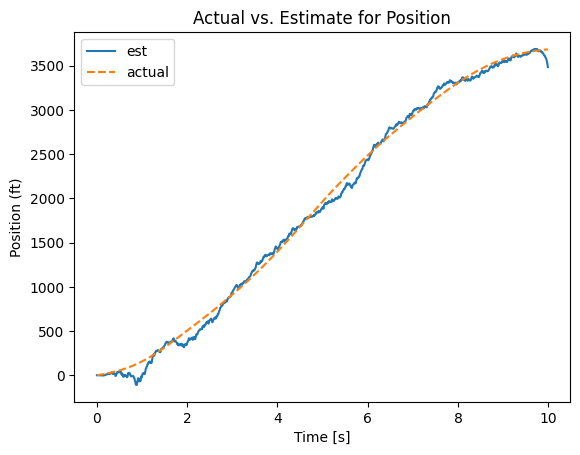

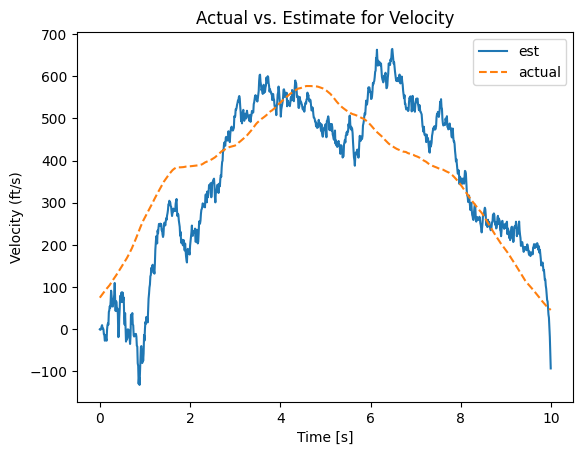

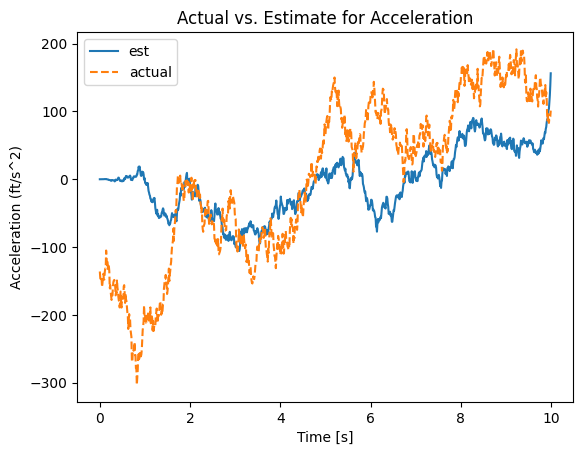

In [79]:
plt.figure()
plt.title('Actual vs. Estimate for Position')
plt.plot(time, x_hat_hist[:, 0, 0], label='est')
plt.plot(time, x_hist[:, 0, 0], linestyle='--', label='actual')
plt.ylabel('Position (ft)')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

plt.figure()
plt.title('Actual vs. Estimate for Velocity')
plt.plot(time, x_hat_hist[:, 1, 0], label='est')
plt.plot(time, x_hist[:, 1, 0], linestyle='--', label='actual')
plt.ylabel('Velocity (ft/s)')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

plt.figure()
plt.title('Actual vs. Estimate for Acceleration')
plt.plot(time, x_hat_hist[:, 2, 0], label='est')
plt.plot(time, x_hist[:, 2, 0], linestyle='--', label='actual')
plt.ylabel('Acceleration (ft/s^2)')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

In [95]:
n_sims = 1000

K_hist = np.zeros((len(time), 3, 1))
x_hist = np.zeros((len(time), 3, 1))
dx_hist = np.zeros((len(time), 3, 1))
z_hist = np.zeros(len(time))
x_hat_hist = np.zeros((len(time), 3, 1))
dx_hat_hist = np.zeros((len(time), 3, 1))
error_hist = np.zeros((n_sims, len(time), 3, 1))
res_hist = np.zeros((n_sims, len(time)))

for j in range(n_sims):
    print("sim: ", j+1, (100*(j+1))/n_sims, " % complete \r", end="")
    time, P, K, x, dx, z, x_hat, dx_hat, residual = run_sim()
    # print(np.mean(residual[1]*residual[np.random.randint(2, len(time), len(time) -1)]))
    error_hist[j, :, :, :] = x_hat - x
    res_hist[j, :] = residual
    # P_hist += P

# P_hist_avg = P_hist/n_sims    
error_hist_avg = np.mean(error_hist, axis=0)

1.4787193038126423
[[ 76861.44688439  74739.48929886 -31352.30201687]
 [ 74739.48929886  75758.55036705 -34048.65338622]
 [-31352.30201687 -34048.65338622  20087.3711666 ]]


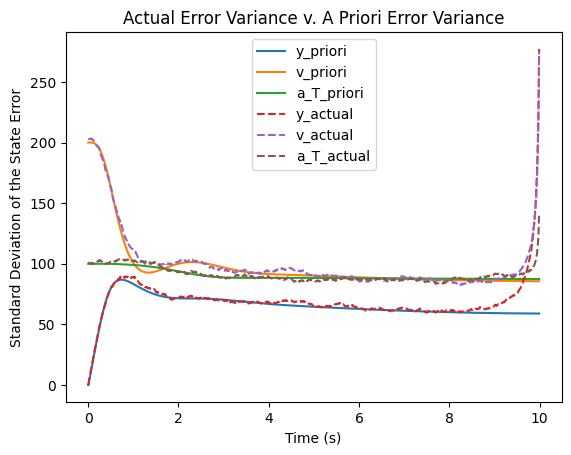

In [99]:
P_hist = np.zeros((len(time), 3, 3))

res = 0
for j in range(n_sims):
    res += res_hist[j, 40]*res_hist[j, 500]
    for k in range(len(time)):
        P_hist[k, :, :] += (error_hist[j, k] - error_hist_avg[k]) @ (error_hist[j, k] - error_hist_avg[k]).T

res / n_sims
print(res)
# P_hist = np.var(error_hist, axis=0)
P_hist = P_hist/n_sims

plt.plot(time, np.sqrt(P[:, 0, 0]), label='y_priori')
plt.plot(time, np.sqrt(P[:, 1, 1]), label='v_priori')
plt.plot(time, np.sqrt(P[:, 2, 2]), label='a_T_priori')
plt.plot(time, np.sqrt(P_hist[:, 0, 0]), label='y_actual', linestyle='--')
plt.plot(time, np.sqrt(P_hist[:, 1, 1]), label='v_actual', linestyle='--')
plt.plot(time, np.sqrt(P_hist[:, 2, 2]), label='a_T_actual', linestyle='--')
plt.title('Actual Error Variance v. A Priori Error Variance')
plt.xlabel('Time (s)')
plt.ylabel('Standard Deviation of the State Error')
plt.legend()
print(P_hist[-1])

In [ ]:
def run_sim2():
    # Constants
    V_c = 300 # ft/s
    R_1 = 15*10e-6 # rad^2/s
    R_2 = 1.67*10e-3 # rad^2/s^3
    t_f = 10 # s
    tau = 2.0 # s

    E_a_T_2 = 100**2 # (ft/sec^2)^2
    E_a_T = 0
    E_y_t0 = 0
    E_y_t0_2 = 0

    E_v_t0 = 0
    E_v_t0_2 = 200**2 # (ft/sec)^2

    W = np.array([[0, 0, 0],
                [0, 0, 0],
                [0, 0, E_a_T_2]])

    a_p = 0
    
    F = np.array([[0, 1, 0],
                [0, 0, -1],
                [0, 0, -1/tau]])

    B = np.array([[0, 1, 0]]).T

    G = np.array([[0, 0, 1]]).T

    # Sim startup
    dt = 0.01 # s
    time = np.arange(0, t_f, dt)

    H = np.array([[1/(V_c*t_f), 0, 0]])
    V = R_1 + R_2/(t_f**2)

    P = np.array([[0, 0, 0],
                [0, E_v_t0_2, 0],
                [0, 0, E_a_T_2]])
    K = P@H.T/V

    n = np.random.normal(0, np.sqrt(V/dt))
    w_a_T = np.random.normal(E_a_T, np.sqrt(E_a_T_2/dt))


    lambda_ = 0.25
    a_T_switch = np.ones(len(time))
    a_T = np.random.normal(E_a_T, np.sqrt(E_a_T_2))
    a_T_switch[0] = 1 if np.random.rand() < 0.5 else -1
    t = 0
    while t < time[-1]:
        T_n = -np.log(np.random.rand()) / lambda_  # Generate next switch time
        t += T_n
        if t >= t_f:
            break
        index = int(t / dt)
        a_T_switch[index:] *= -1  # Flip sign after switching time
    # print(a_T_switch)


    x = np.array([[0.0],
                [np.random.normal(E_v_t0, np.sqrt(E_v_t0_2))], 
                [a_T*a_T_switch[0]]])
    dx = np.zeros((3, 1))
    z = H@x + n
    x_hat = np.zeros((3, 1))
    dx_hat = dx_hat_prop(F, x_hat, K, z, V_c, t_f, 0)

    P_hist = np.zeros((len(time), 3, 3))
    K_hist = np.zeros((len(time), 3, 1))
    x_hist = np.zeros((len(time), 3, 1))
    dx_hist = np.zeros((len(time), 3, 1))
    z_hist = np.zeros(len(time))
    residual = np.zeros(len(time))
    x_hat_hist = np.zeros((len(time), 3, 1))
    dx_hat_hist = np.zeros((len(time), 3, 1))

    P_hist[0] = P
    K_hist[0] = K
    x_hist[0] = x
    dx_hist[0] = dx
    z_hist[0] = np.squeeze(z)
    x_hat_hist[0] = x_hat
    dx_hat_hist[0] = dx_hat

    for i in range(1, len(time)):
        V = R_1 + R_2/((t_f - time[i])**2)
        H = np.array([[1/(V_c*(t_f - time[i])), 0, 0]])

        # Variance update
        dP = F@P + P@F.T - P@H.T*(1/V)*H@P+W
        P = P + dP*dt
        P_hist[i, :, :] = P

        # Kalman Gain
        K = P@H.T/V
        K_hist[i, :, :] = K

        dx_hat = F@x_hat + K@(z - (H@x_hat))
        dx_hat_hist[i] = dx_hat

        x_hat = x_hat + dx_hat*dt
        x_hat_hist[i] = x_hat


        n = np.random.normal(0, np.sqrt(V/dt))
        w_a_T = np.random.normal(E_a_T, np.sqrt(E_a_T_2/dt))
        
        dx = F@x + G*w_a_T
        dx_hist[i] = dx

        x = x + dx*dt
        x[2, 0] = x[2, 0] * a_T_switch[i]
        x_hist[i] = x
        
        z = H@x + n
        z_hist[i] = np.squeeze(z)
        residual[i] = np.squeeze(z - H@x_hat)

    return time, P_hist, K_hist, x_hist, dx_hist, z_hist, x_hat_hist, dx_hat_hist, residual


    

In [110]:
n_sims = 1000

K_hist = np.zeros((len(time), 3, 1))
x_hist = np.zeros((len(time), 3, 1))
dx_hist = np.zeros((len(time), 3, 1))
z_hist = np.zeros(len(time))
x_hat_hist = np.zeros((len(time), 3, 1))
dx_hat_hist = np.zeros((len(time), 3, 1))
error_hist = np.zeros((n_sims, len(time), 3, 1))
res_hist = np.zeros((n_sims, len(time)))

for j in range(n_sims):
    print("sim: ", j+1, (100*(j+1))/n_sims, " % complete \r", end="")
    time, P, K, x, dx, z, x_hat, dx_hat, residual = run_sim2()
    # print(np.mean(residual[1]*residual[np.random.randint(2, len(time), len(time) -1)]))
    error_hist[j, :, :, :] = x_hat - x
    res_hist[j, :] = residual
    # P_hist += P

# P_hist_avg = P_hist/n_sims    
error_hist_avg = np.mean(error_hist, axis=0)

0.9005665491942363
[[ 52485.70994369  49214.17486794 -19648.72569741]
 [ 49214.17486794  48225.5693848  -20451.98607484]
 [-19648.72569741 -20451.98607484  16500.81319728]]


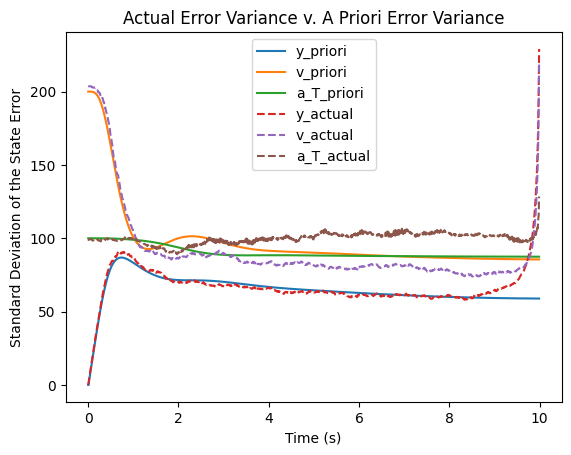

In [ ]:
P_hist = np.zeros((len(time), 3, 3))

res = 0
for j in range(n_sims):
    res += res_hist[j, 40]*res_hist[j, 500]
    for k in range(len(time)):
        P_hist[k, :, :] = (error_hist[j, k] - error_hist_avg[k]) @ (error_hist[j, k] - error_hist_avg[k]).T

res / n_sims
print(res)
# P_hist = np.var(error_hist, axis=0)
P_hist = P_hist/n_sims

plt.plot(time, np.sqrt(P[:, 0, 0]), label='y_priori')
plt.plot(time, np.sqrt(P[:, 1, 1]), label='v_priori')
plt.plot(time, np.sqrt(P[:, 2, 2]), label='a_T_priori')
plt.plot(time, np.sqrt(P_hist[:, 0, 0]), label='y_actual', linestyle='--')
plt.plot(time, np.sqrt(P_hist[:, 1, 1]), label='v_actual', linestyle='--')
plt.plot(time, np.sqrt(P_hist[:, 2, 2]), label='a_T_actual', linestyle='--')
plt.title('Actual Error Variance v. A Priori Error Variance')
plt.xlabel('Time (s)')
plt.ylabel('Standard Deviation of the State Error')
plt.legend()
print(P_hist[-1])